Google Drive에 Mount

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


작업 위치로 이동

In [3]:
%cd /content/drive/MyDrive/kurly_hurry_holy_moly/demand_forecasting

/content/drive/MyDrive/kurly_hurry_holy_moly/demand_forecasting


필요한 라이브러리 Import

In [32]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import time
from tqdm.auto import tqdm
import os
from matplotlib import pyplot as plt


각 데이터 파일 정제하여 RDS 축적 (우선 로컬로 진행)

In [26]:
data_list = os.listdir('datasets')
df = pd.DataFrame()

# 모든 데이터 파일 정제 및 합치기
for data in tqdm(data_list):
    path = 'datasets/' + data
    temp = pd.read_csv(path)
    temp = temp[temp['Order ID'].apply(lambda x: len(str(x)) == 6)]
    df = pd.concat([df, temp], ignore_index=True)

# 날짜 str -> Datetime 변환
df['Datetime'] = df['Order Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%y %H:%M'))

# 정렬을 위하여 str 형태로 일자 데이터 추가
df['Date'] = df['Datetime'].apply(lambda x: datetime.strftime(x, '%Y-%m-%d'))

# 추가 데이터로 요일 정보 추가
df['Day Of Week'] = df['Datetime'].apply(lambda x: x.weekday())

# Correlation 계산을 위하여 timestamp 추가
df['Timestamp'] = df['Datetime'].apply(lambda x: time.mktime(x.timetuple()))

# 날짜 별로 정렬
df = df.sort_values('Datetime').reset_index(drop=True)

# 데이터 포맷 변환
df['Quantity Ordered'] = df['Quantity Ordered'].apply(lambda x: int(x))
df['Price Each'] = df['Price Each'].apply(lambda x: float(x))

print(len(df))
df.head()

  0%|          | 0/12 [00:00<?, ?it/s]

185950


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Datetime,Date,Day Of Week,Timestamp
0,147268,Wired Headphones,1,11.99,01/01/19 03:07,"9 Lake St, New York City, NY 10001",2019-01-01 03:07:00,2019-01-01,1,1.546312e+09
1,148041,USB-C Charging Cable,1,11.95,01/01/19 03:40,"760 Church St, San Francisco, CA 94016",2019-01-01 03:40:00,2019-01-01,1,1.546314e+09
2,149343,Apple Airpods Headphones,1,150.00,01/01/19 04:56,"735 5th St, New York City, NY 10001",2019-01-01 04:56:00,2019-01-01,1,1.546319e+09
3,149964,AAA Batteries (4-pack),1,2.99,01/01/19 05:53,"75 Jackson St, Dallas, TX 75001",2019-01-01 05:53:00,2019-01-01,1,1.546322e+09
4,149350,USB-C Charging Cable,2,11.95,01/01/19 06:03,"943 2nd St, Atlanta, GA 30301",2019-01-01 06:03:00,2019-01-01,1,1.546323e+09


분석에 용이한 형태로 데이터 변환

In [29]:
date_list = list(set(list(df['Date'])))
df_date = pd.DataFrame()
for dt in tqdm(date_list):
    temp = df[df['Date'] == dt].reset_index(drop=True)
    item_list = list(set(list(temp['Product'])))
    for item in item_list:
        temp2 = temp[temp['Product'] == item].reset_index(drop=True)
        total = sum(list(temp2['Quantity Ordered']))
        dow = temp2.loc[0, 'Day Of Week']
        price = temp2.loc[0, 'Price Each']
        df_date.loc[df_date.shape[0], 'Date'] = dt
        df_date.loc[df_date.shape[0]-1, 'Product'] = item
        df_date.loc[df_date.shape[0]-1, 'Quantity'] = total
        df_date.loc[df_date.shape[0]-1, 'Price Each'] = price
        df_date.loc[df_date.shape[0]-1, 'Day Of Week'] = dow
df_date.head()

  0%|          | 0/366 [00:00<?, ?it/s]

,Date,Product,Quantity,Price Each,Day Of Week
0,2019-12-04,Vareebadd Phone,10.0,400.00,2.0
1,2019-12-04,AA Batteries (4-pack),108.0,3.84,2.0
2,2019-12-04,Macbook Pro Laptop,23.0,1700.00,2.0
3,2019-12-04,USB-C Charging Cable,87.0,11.95,2.0
4,2019-12-04,LG Dryer,2.0,600.00,2.0


EDA 작업을 위하여 그룹화 진행 및 그래프 생성

In [30]:
group_df = df_date.groupby(['Day Of Week', 'Product']).mean().reset_index()
group_df

,Day Of Week,Product,Quantity,Price Each
0,0.0,20in Monitor,11.711538,109.99
1,0.0,27in 4K Gaming Monitor,17.307692,389.99
2,0.0,27in FHD Monitor,20.673077,149.99
3,0.0,34in Ultrawide Monitor,15.634615,379.99
4,0.0,AA Batteries (4-pack),76.730769,3.84
...,...,...,...,...
128,6.0,ThinkPad Laptop,11.326923,999.99
129,6.0,USB-C Charging Cable,65.538462,11.95
130,6.0,Vareebadd Phone,6.235294,400.00
131,6.0,Wired Headphones,56.730769,11.99


비교를 위하여 월요일과 토요일의 추이 비교

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

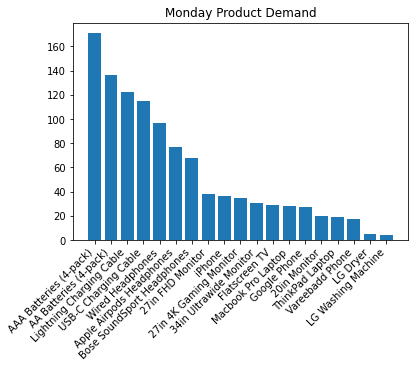

In [37]:
# 월요일

monday = df_date[df_date['Day Of Week'] == 0].sort_values('Quantity', ascending=False).reset_index(drop=True)
plt.bar(list(monday['Product']), list(monday['Quantity']))
plt.title('Monday Product Demand')
plt.xticks(rotation=45, ha='right')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18],
 <a list of 19 Text major ticklabel objects>)

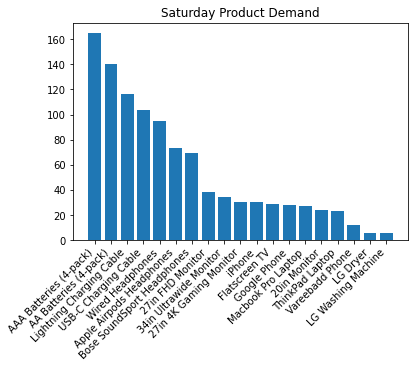

In [38]:
# 토요일

saturday = df_date[df_date['Day Of Week'] == 5].sort_values('Quantity', ascending=False).reset_index(drop=True)
plt.bar(list(saturday['Product']), list(saturday['Quantity']))
plt.title('Saturday Product Demand')
plt.xticks(rotation=45, ha='right')

머신러닝 모델 적용을 위한 데이터 변환

In [69]:
# 필요한 모듈 설치
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [79]:
# 필요한 모듈 Import
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.neural_network import MLPRegressor
import xgboost
import catboost

In [54]:
# 불필요한 컬럼 제거 및 제품명의 Label Encoding 진행
df_date = df_date.drop(columns=['Date', 'product'])
df_date['Product'] = LabelEncoder().fit_transform(list(df_date['Product']))
df_date

,Product,Quantity,Price Each,Day Of Week
0,16,10.0,400.00,2.0
1,4,108.0,3.84,2.0
2,13,23.0,1700.00,2.0
3,15,87.0,11.95,2.0
4,10,2.0,600.00,2.0
...,...,...,...,...
6822,17,81.0,11.99,3.0
6823,13,17.0,1700.00,3.0
6824,15,107.0,11.95,3.0
6825,1,28.0,389.99,3.0


In [56]:
train = df_date.copy()
target = train.pop('Quantity')
x_train, x_test, y_train, y_test = train_test_split(train, target, test_size = 0.2)

In [72]:
train.corr()

,Product,Price Each,Day Of Week
Product,1.000000,0.331314,-0.000550
Price Each,0.331314,1.000000,0.000083
Day Of Week,-0.000550,0.000083,1.000000


In [80]:
# Gradient Boosting을 활용한 XGBRegressor
model = xgboost.XGBRegressor()
model.fit(x_train, y_train)
y = model.predict(x_test)
print(mean_absolute_error(y, y_test))
print(math.sqrt(mean_squared_error(y, y_test)))
print(r2_score(y, y_test))

[13:16:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
8.49587351982625
13.512275098024674
0.734758563049531


In [81]:
# Gradient Boosting을 활용한 CatBoostRegressor

model2 = catboost.CatBoostRegressor()
model2.fit(x_train, y_train)
y = model2.predict(x_test)
print(mean_absolute_error(y, y_test))
print(math.sqrt(mean_squared_error(y, y_test)))
print(r2_score(y, y_test))

Learning rate set to 0.053539
0:	learn: 27.0086837	total: 3.48ms	remaining: 3.48s
1:	learn: 25.9342506	total: 6.71ms	remaining: 3.35s
2:	learn: 24.8791480	total: 8.05ms	remaining: 2.67s
3:	learn: 23.9933784	total: 9.04ms	remaining: 2.25s
4:	learn: 23.0969660	total: 9.99ms	remaining: 1.99s
5:	learn: 22.2384044	total: 11ms	remaining: 1.82s
6:	learn: 21.4574050	total: 12ms	remaining: 1.7s
7:	learn: 20.7329927	total: 13ms	remaining: 1.61s
8:	learn: 20.1113478	total: 13.8ms	remaining: 1.52s
9:	learn: 19.4651061	total: 14.9ms	remaining: 1.48s
10:	learn: 18.9008538	total: 15.9ms	remaining: 1.43s
11:	learn: 18.4136125	total: 17.3ms	remaining: 1.43s
12:	learn: 17.8911619	total: 25.4ms	remaining: 1.93s
13:	learn: 17.4234833	total: 27.9ms	remaining: 1.97s
14:	learn: 16.9768273	total: 31.3ms	remaining: 2.05s
15:	learn: 16.5895774	total: 34.6ms	remaining: 2.13s
16:	learn: 16.2223601	total: 37.9ms	remaining: 2.19s
17:	learn: 15.8752573	total: 41.2ms	remaining: 2.25s
18:	learn: 15.5652591	total: 44.5

In [82]:
# Neural Network Regressor

model3 = MLPRegressor()
model3.fit(x_train, y_train)
y = model3.predict(x_test)
print(mean_absolute_error(y, y_test))
print(math.sqrt(mean_squared_error(y, y_test)))
print(r2_score(y, y_test))

10.456962554260725
14.990364918323477
0.62084706224852


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,
